<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/PyStan/LinearRegression_NormalLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import numpy as np
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import pickle
with open("/content/LinearRegression/linear_regression_normal_distribution",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[-1.4144772 ],
         [ 1.6039085 ],
         [ 2.293806  ],
         [ 3.8276772 ],
         [ 1.999692  ],
         [ 1.0609426 ],
         [ 1.2900534 ],
         [-2.3558607 ],
         [ 3.0193057 ],
         [-0.89879274]], dtype=float32),
  'y': array([ 1.2143412,  7.422146 , 10.44427  , 12.321105 ,  7.133485 ,
          6.848776 ,  6.8407617, -1.5791223, 11.820506 ,  1.6998756],
        dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [51]:
X = data['data']['x']
Y = data['data']['y']

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)
mean_prior = data['prior']['mean']
var_prior = data['prior']['var']
diag=jnp.identity(10)

In [ ]:
"""
data {
    int<lower=0> n;
    real x[n];
    real y[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real sigma;
}
transformed parameters {
    real mu[n];
    for (i in 1:n) {
        mu[i] <- a*x[i] + b;
        }
}
model {
    sigma ~ uniform(0, 20);
    y ~ normal(mu, sigma);
}"""

In [47]:
LinearRegression_NormalDist="""
data {
  int<lower=0> N;
  matrix[N,2] x;
  vector[N] y;
  vector[2] mean_prior;
  matrix[2,2] var_prior;
  matrix[10,10] diag;
}
parameters {
  vector[2] theta;
}
model {
  theta ~ multi_normal(mean_prior,var_prior);
  y ~ multi_normal(x*theta,diag);
}
"""

In [48]:
model_LinearReg_Normal = pystan.StanModel(model_code=LinearRegression_NormalDist)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c729a344239304559e0a3da43070de3 NOW.


In [52]:
data = {
    'N':10,
    'x':X,
    'y':Y,
    'mean_prior':mean_prior,
    'var_prior':var_prior,
    'diag':diag
}

In [53]:
model_LinearReg_Normal_hmc = model_LinearReg_Normal.sampling(data=data, chains=8, warmup=500, iter=1500)

In [54]:
model_LinearReg_Normal_hmc

Inference for Stan model: anon_model_5c729a344239304559e0a3da43070de3.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   4.14  5.9e-3   0.36   3.44    3.9   4.14   4.38   4.84   3632    1.0
theta[2]   2.28  2.8e-3   0.16   1.96   2.17   2.28   2.39    2.6   3507    1.0
lp__      -9.69    0.02   0.98 -12.31 -10.05  -9.41   -9.0  -8.74   3171    1.0

Samples were drawn using NUTS at Sun Jun  5 16:41:08 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5de7e67e10>,
      dtype=object)

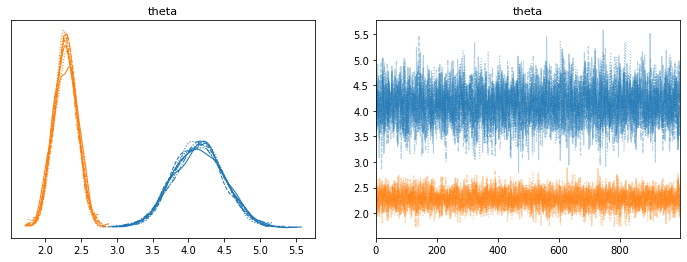

In [55]:
az.plot_trace(model_LinearReg_Normal_hmc, figsize = (12, 4))

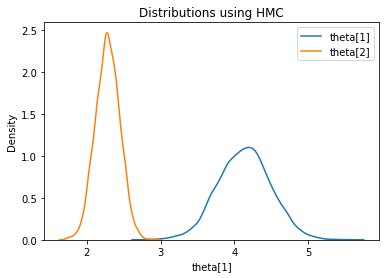

In [58]:
model_LinearReg_Normal_df = model_LinearReg_Normal_hmc.to_dataframe()
alpha_hmc = model_LinearReg_Normal_df['theta[1]']
sns.kdeplot(alpha_hmc,label="theta[1]")

beta_hmc = model_LinearReg_Normal_df['theta[2]']
sns.kdeplot(beta_hmc,label="theta[2]")

plt.title("Distributions using HMC")
plt.legend()
plt.show()

#**Using Variational Inference**

In [59]:
model_LinearReg_Normal_vi=model_LinearReg_Normal.vb(data=data)

In [62]:
model_LinearReg_Normal_vi['mean_pars']

[4.112058530687574, 2.25467172996517]

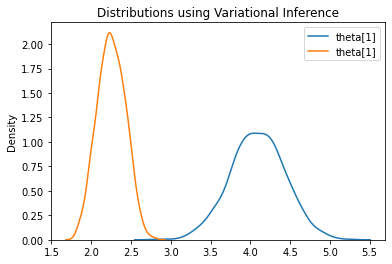

In [60]:
alpha_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[0])
sns.kdeplot(alpha_vi,label="theta[1]")

beta_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[1])
sns.kdeplot(beta_vi,label="theta[1]")

plt.title("Distributions using Variational Inference")
plt.legend()
plt.show()

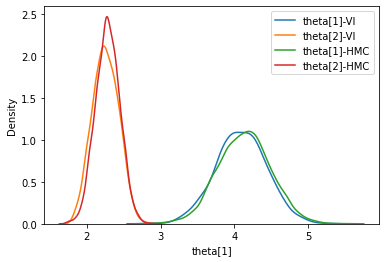

In [64]:
sns.kdeplot(alpha_vi,label="theta[1]-VI")
sns.kdeplot(beta_vi,label="theta[2]-VI")

sns.kdeplot(alpha_hmc,label="theta[1]-HMC")
sns.kdeplot(beta_hmc,label="theta[2]-HMC")

plt.legend()
plt.show()